# Week 6

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# 1
df_train = pd.read_csv("train.tsv", sep="\t")
df_test = pd.read_csv("test.tsv", sep="\t")

In [4]:
def data_cleaning(df):
    print(df.shape)
    df_cleaned = df.sort_values(["user_id", "item_id", "timestamp"],ascending=[True,True, True])
    print(df_cleaned.shape)
    df_cleaned = df_cleaned.dropna(subset=["user_id", "item_id", "timestamp"])
    print(df_cleaned.shape)
    df_cleaned = df_cleaned.drop_duplicates(keep="last", subset=["user_id", "item_id"])
    print(df_cleaned.shape)
    return df_cleaned

df_train = data_cleaning(df_train)
df_test = data_cleaning(df_test)

(11000, 4)
(11000, 4)
(11000, 4)
(9913, 4)
(3000, 4)
(3000, 4)
(3000, 4)
(1822, 4)


In [ ]:
(11000, 4)
(11000, 4)
(11000, 4)
(9913, 4)
(3000, 4)
(3000, 4)
(3000, 4)
(1822, 4)

NameError: name 'df_cleaned' is not defined

In [4]:
3000-1822

1178

In [5]:
11000 - 9913

1087

In [6]:
def make_test_data_consistent(df_test, users_in_training_dataset):
    # drop all test records for users that aren't present in the train dataset
    return df_test[df_test.user_id.isin(users_in_training_dataset)]

In [7]:
df_test = make_test_data_consistent(df_test, df_train.user_id.tolist())

All users present in the test dataset are present in the training dataset. Hence, we won't try to evaluate the models based on how they handle the cold start problem

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1822 entries, 2117 to 817
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item_id    1822 non-null   object 
 1   user_id    1822 non-null   object 
 2   rating     1822 non-null   float64
 3   timestamp  1822 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 71.2+ KB


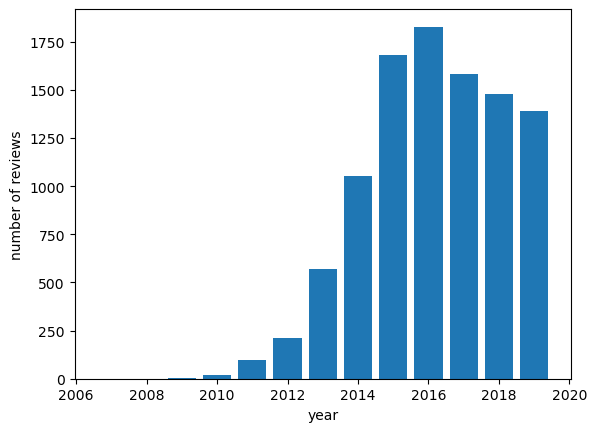

In [9]:
review_years_training_dataset = pd.to_datetime(df_train.timestamp, unit='ms').dt.year
plt.bar(*np.unique(review_years_training_dataset, return_counts=True))
plt.xlabel("year")
plt.ylabel("number of reviews")
plt.show()

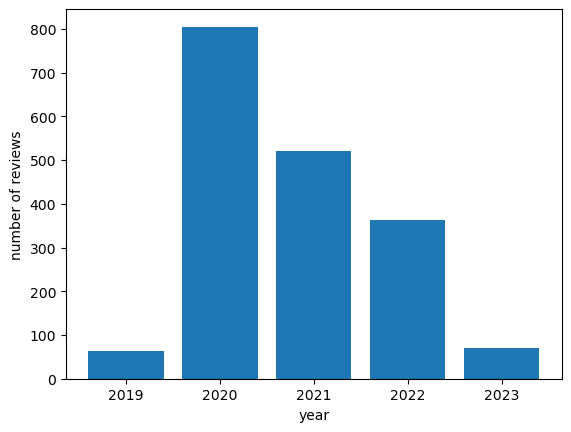

In [10]:
review_years_testing_dataset = pd.to_datetime(df_test.timestamp, unit='ms').dt.year
plt.bar(*np.unique(review_years_testing_dataset, return_counts=True))
plt.xlabel("year")
plt.ylabel("number of reviews")
plt.show()

It seems that the whole dataset was split based on the timestamp. No leaks of future info in the dataset. If there were leakage, that would mean that the system would learn the user's behaviour based on their future behaviour in order to estimate their past behaviour. Also using temporal split improves the measurement of generalization of the model.

In [11]:
avg_item_rating_training_dataset = df_train[["item_id","rating"]].groupby("item_id", as_index=False).agg(avg_rating=("rating","mean"), count=("rating","size"))
avg_high_rated_item_training_dataset = avg_item_rating_training_dataset[avg_item_rating_training_dataset.avg_rating >= 3]
avg_high_rated_item_freq_training_dataset = avg_high_rated_item_training_dataset.shape[0]/avg_item_rating_training_dataset.shape[0]

avg_item_rating_test_dataset = df_test[["item_id","rating"]].groupby("item_id", as_index=False).agg(avg_rating=("rating","mean"), count=("rating","size"))
avg_high_rated_item_test_dataset = avg_item_rating_test_dataset[avg_item_rating_test_dataset.avg_rating >= 3]
avg_high_rated_item_freq_test_dataset = avg_high_rated_item_test_dataset.shape[0]/avg_item_rating_test_dataset.shape[0]
print(f"Freq of high-rated reviews for items - train [{avg_high_rated_item_freq_training_dataset}], test [{avg_high_rated_item_freq_test_dataset}]")

Freq of high-rated reviews for items - train [1.0], test [0.9733656174334141]


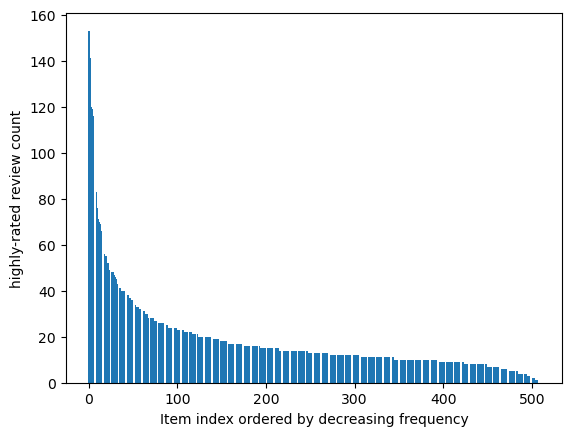

In [12]:
# High rates per musical instrument
df_train_high_ratings_count_per_item = df_train[["item_id","rating"]].groupby("item_id", as_index=False).agg(lambda x: sum([1 if item >= 3.0 else 0 for item in x])).sort_values("rating", ascending=False)
plt.bar(x=range(df_train_high_ratings_count_per_item.shape[0]), height=df_train_high_ratings_count_per_item.iloc[:,1])
plt.xlabel("Item index ordered by decreasing frequency")
plt.ylabel("highly-rated review count")
plt.show()

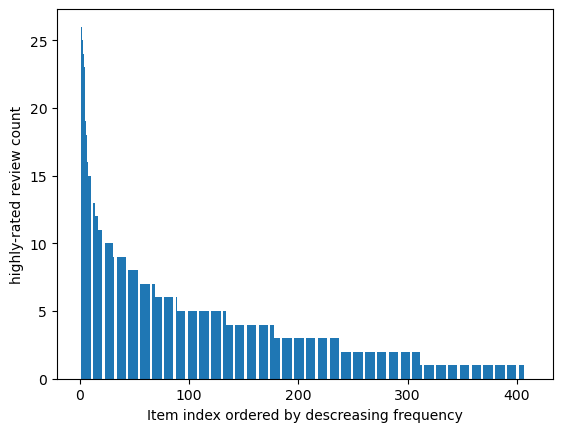

In [13]:
# High rates per musical instrument
df_test_high_ratings_count_per_item = df_test[["item_id","rating"]].groupby("item_id", as_index=False).agg(lambda x: sum([1 if item >= 3.0 else 0 for item in x])).sort_values("rating", ascending=False)
plt.bar(x=range(df_test_high_ratings_count_per_item.shape[0]), height=df_test_high_ratings_count_per_item.iloc[:,1])
plt.xlabel("Item index ordered by descreasing frequency")
plt.ylabel("highly-rated review count")
plt.show()

In [14]:
print("Train dataset top 5 most highly rated items:")
print(avg_item_rating_training_dataset.sort_values(["avg_rating", "count"], ascending=[False, False]).iloc[:5,:])

Train dataset top 5 most highly rated items:
        item_id  avg_rating  count
286  B07N2HQ1T7         5.0     28
254  B07C9YCY5J         5.0     14
31   B000U0DU34         5.0     13
473  B0BT2W3TTM         5.0     13
298  B07S19XSPV         5.0     12


In [15]:
print("Test dataset top 5 most highly rated items:")
print(avg_item_rating_test_dataset.sort_values(["avg_rating", "count"], ascending=[False, False]).iloc[:5,:])

Test dataset top 5 most highly rated items:
        item_id  avg_rating  count
278  B09G5KLKX2         5.0     10
330  B0B8F6LD9F         5.0     10
365  B0BL8897K3         5.0      9
76   B00NPAMDQ6         5.0      8
186  B07CRK35NG         5.0      8


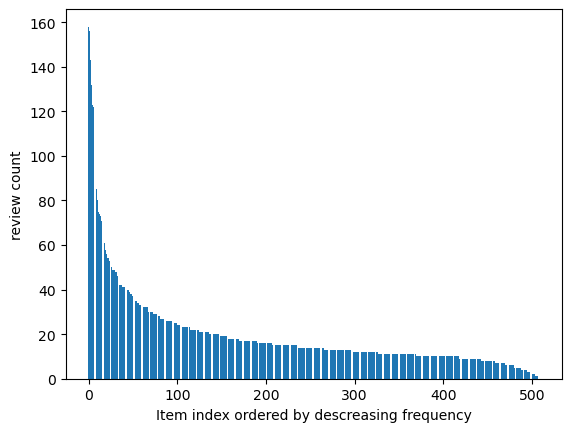

In [16]:
df_per_item_review_count_train_dataset = df_train.groupby("item_id", as_index=False).size().sort_values(["size"], ascending=[False])
plt.bar(x=range(df_per_item_review_count_train_dataset.shape[0]), height=df_per_item_review_count_train_dataset.iloc[:,1])
plt.xlabel("Item index ordered by descreasing frequency")
plt.ylabel("review count")
plt.show()

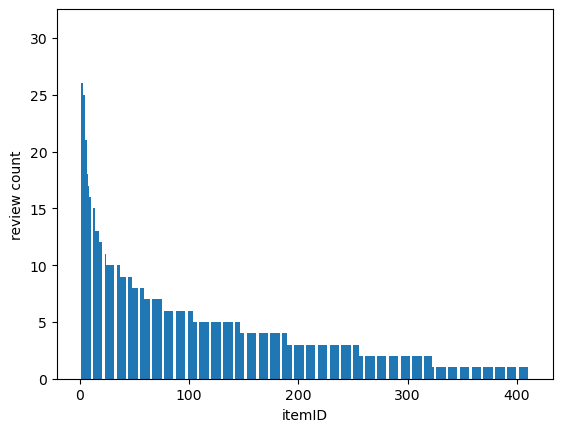

In [17]:
import matplotlib.pyplot as plt

df_per_item_review_count_test_dataset = df_test.groupby("item_id", as_index=False).size().sort_values(["size"], ascending=[False])
plt.bar(x=range(df_per_item_review_count_test_dataset.shape[0]), height=df_per_item_review_count_test_dataset.iloc[:,1])
plt.xlabel("itemID")
plt.ylabel("review count")
plt.show()

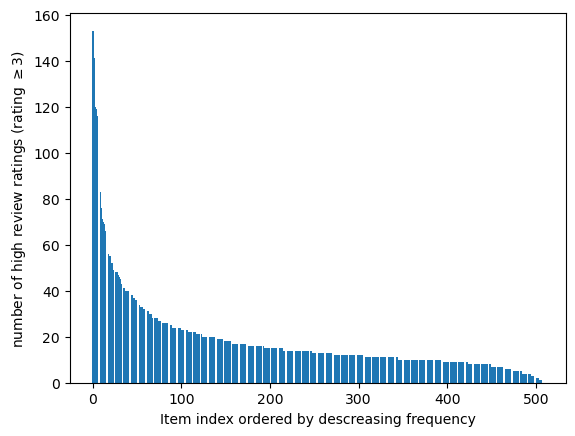

In [18]:
count_high_ratings_per_item_train = df_train[df_train["rating"] >= 3]["item_id"].value_counts()
plt.bar(x=range(count_high_ratings_per_item_train.shape[0]), height=count_high_ratings_per_item_train)
plt.xlabel("Item index ordered by descreasing frequency")
plt.ylabel(r"number of high review ratings (rating $\geq$3)")
plt.show()

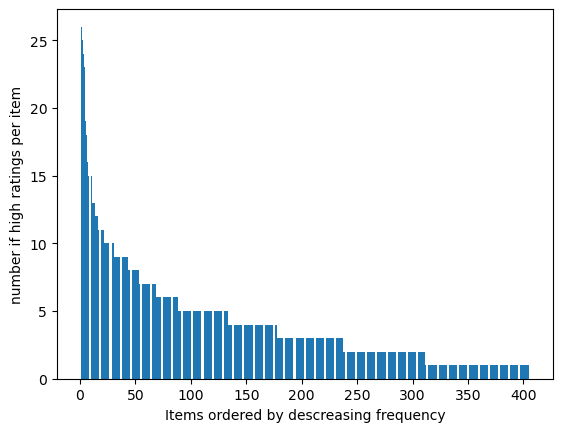

In [19]:
count_high_ratings_per_item_test = df_test[df_test["rating"] >= 3]["item_id"].value_counts()
plt.bar(x=range(count_high_ratings_per_item_test.shape[0]), height=count_high_ratings_per_item_test)
plt.xlabel("Items ordered by descreasing frequency")
plt.ylabel("number if high ratings per item")
plt.show()

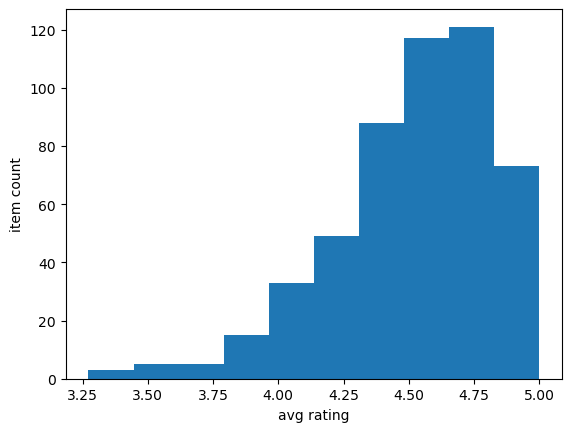

In [20]:
df_per_item_review_avg_rating_train_dataset = df_train.groupby("item_id")["rating"].mean()
plt.hist(df_per_item_review_avg_rating_train_dataset)
plt.xlabel("avg rating")
plt.ylabel("item count")
plt.show()

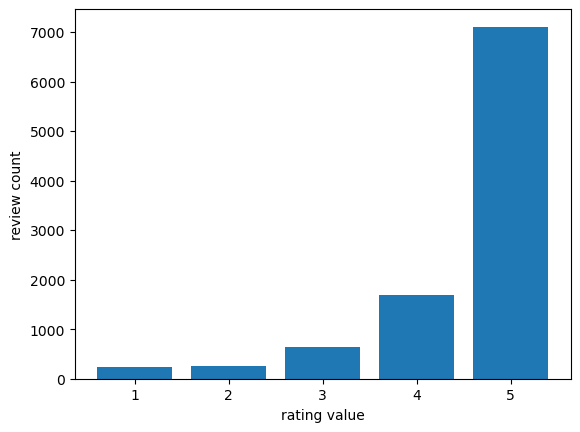

In [21]:
df_per_item_review_avg_rating_train_dataset = df_train["rating"]
plt.bar(*np.unique(df_train["rating"], return_counts=True))
plt.xlabel("rating value")
plt.ylabel("review count")
plt.show()

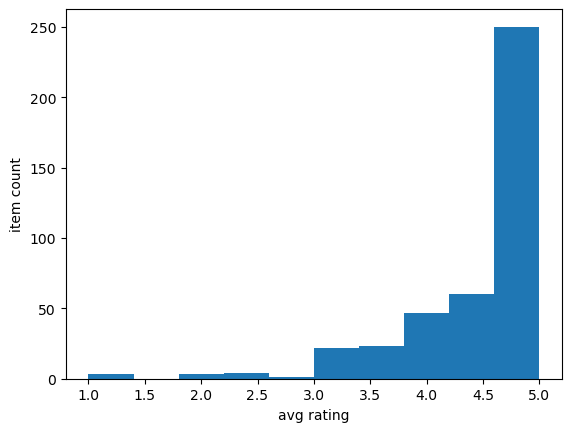

In [22]:
df_per_item_review_avg_rating_test_dataset = df_test.groupby("item_id")["rating"].mean()
plt.hist(df_per_item_review_avg_rating_test_dataset)
plt.xlabel("avg rating")
plt.ylabel("item count")
plt.show()

The discrepancy between the distributions in the train and test dataset is concerning. Given that in the training dataset all of the ratings are >=3, this would mean that for unobserved items the system will predict ratings >=3. However, in reality the real rating might be lower than 3.

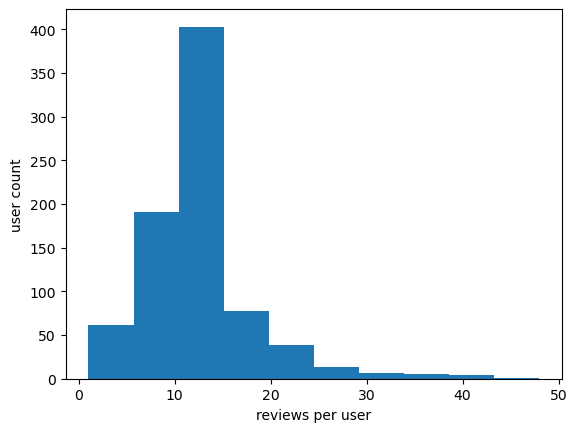

In [23]:
df_per_item_review_count_train_dataset = df_train.groupby("user_id").size()
plt.hist(df_per_item_review_count_train_dataset)
plt.xlabel("reviews per user")
plt.ylabel("user count")
plt.show()

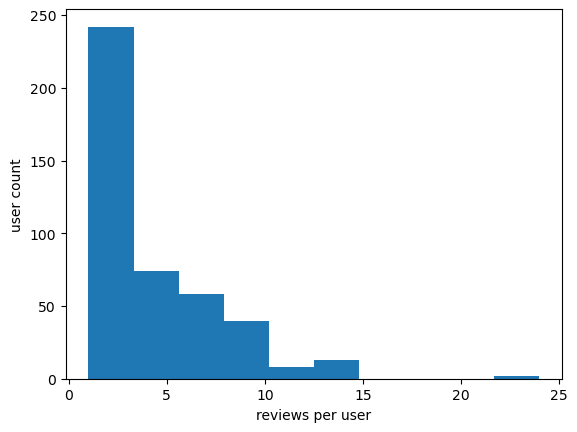

In [24]:
df_per_item_review_count_test_dataset = df_test.groupby("user_id").size()
plt.hist(df_per_item_review_count_test_dataset)
plt.xlabel("reviews per user")
plt.ylabel("user count")
plt.show()

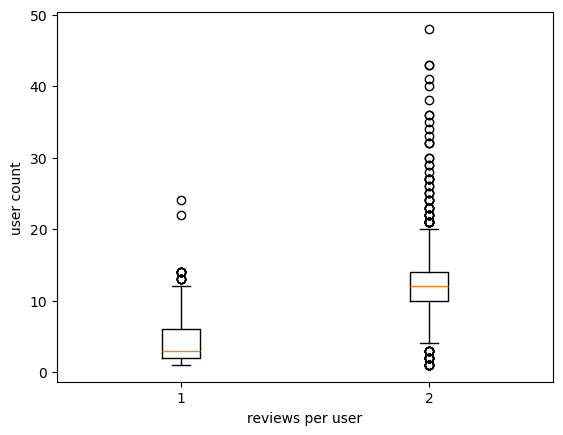

In [25]:
df_per_item_review_count_test_dataset = df_test.groupby("user_id").size()
plt.boxplot([df_per_item_review_count_test_dataset, df_per_item_review_count_train_dataset])
plt.xlabel("reviews per user")
plt.ylabel("user count")
plt.show()

In [26]:
df_train.shape[0] + df_test.shape[0]

11735

In [27]:
df_train

,item_id,user_id,rating,timestamp
6582,B005M0MUQK,AE23LDQTB7L76AP6E6WPBFVYL5DA,4.0,1523727684523
7338,B007T8CUNG,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1538338679388
5709,B015IJIO5U,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1550441940530
8394,B09NLV5LBK,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1565530500329
10866,B0BSR996X8,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1565529596545
...,...,...,...,...
7095,B0928H8KFQ,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,1.0,1567116669646
6145,B09396NY1C,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,1.0,1507288252495
10394,B095XZJ99J,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,5.0,1551528681939
5962,B09QZJ57YW,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,4.0,1563049606419


In [28]:
# Data sparsity
unique_users_num = len(set(df_train.user_id.tolist()) | set(df_test.user_id.tolist()))
unique_items_num = len(set(df_train.item_id.tolist()) | set(df_test.item_id.tolist()))

print(f"Number of users {unique_users_num}")
print(f"Number of items {unique_items_num}")

data_sparsity = 1.0 - (df_train.shape[0] + df_test.shape[0])/ (unique_users_num * unique_items_num)
print(f"Data sparsity is :{data_sparsity}")

Number of users 800
Number of items 518
Data sparsity is :0.9716819498069498


So they \# users and \# items are relatively on the same order. So one cannot directly tell whether user-based or item-based is more appropriate. If users were orders of magnituded more than the items, then item-based would have been preferable

# Week 7

In [67]:
from surprise import Reader, Dataset, KNNWithMeans, SVD
from surprise.model_selection import KFold
from sklearn.metrics import root_mean_squared_error as rmse

In [68]:
from collections import defaultdict
from surprise.prediction_algorithms.predictions import Prediction
from typing import Dict, List

def get_recommendations_per_user(predictions: List[Prediction]) -> Dict[str, List]:
    """Order items from highest recommended to lowest recommended for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
    Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    pred_df = pd.DataFrame(predictions)
    recommendation_ordered_items = pred_df.groupby("uid", group_keys=False).apply(lambda group: group.sort_values("est", ascending=False)
                          .apply(lambda row: (row.iid, row.est), axis=1)
                          .tolist())
    return recommendation_ordered_items

def get_top_k(predictions: List[Prediction], 
              k: int) -> Dict[str, List]:
    """Compute the top-K recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        k(int): The number of recommendation to output for each user.
    Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    # topk = defaultdict(list)
    # pred_df = pd.DataFrame(predictions)
    # filtered_pred_df = pred_df.groupby("uid", group_keys=False).apply(lambda x: x.nlargest(k, "est"))
    # topk = filtered_pred_df.groupby("uid").apply(lambda x: [(row.iid, row.est) for _, row in x.iterrows()])
    topk = defaultdict(list)

    pred_df = pd.DataFrame(predictions)

    # Select top-k predictions per user
    filtered_pred_df = (
        pred_df.sort_values(["uid", "est"], ascending=[True, False])
        .groupby("uid", group_keys=True, as_index=False)
        .head(k)
    )

    # Convert to dictionary of lists
    topk = filtered_pred_df.groupby("uid")[["iid", "est"]].apply(lambda x: list(x.itertuples(index=False, name=None))).to_dict()

    return topk

def print_top_k(user_id: str, topk: Dict[str, List]) -> None:
    user_ratings = topk[user_id]
    print(user_ratings)
    print(f"TOP-{len(user_ratings)} predictions for user {user_id}: {[(item, round(rating,2)) for (item, rating) in user_ratings]}")

In [101]:
import numpy as np
from __future__ import (absolute_import, division, print_function, unicode_literals)
from collections import defaultdict
from surprise import Dataset

def _convert_rating_to_relevance(user: str, recommendations: List[float], df_test: pd.DataFrame) -> float:
    return [1  if ((df_test.user_id == user) & (df_test.item_id == iid) & (df_test.rating >=4)).any() else 0 for (iid, _) in recommendations]

def precision_at_k(top_k_recommendations_per_user: Dict[str,List], 
                   df_test: pd.DataFrame,
                   k: int) -> Dict[str, float]:
    """Compute precision at k for each user
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        df_test: Pandas DataFrame containing user-item ratings in 
            the test split.
    Returns:
        A dict where keys are user ids (str)
        and values are the P@k (float) for each of them
    """

    precisions = defaultdict(float)
    # First map the predictions to each user.
    
    utility_levels_per_user = { 
            user : _convert_rating_to_relevance(user, recommendations, df_test)
            for user, recommendations in top_k_recommendations_per_user.items()
        }

    # Write your code here

    precisions = {user: sum(utility_levels)/k for user,utility_levels in utility_levels_per_user.items()}
    return precisions


def mean_average_precision(top_k_recommendations_per_user:  Dict[str,List], 
                           df_test: pd.DataFrame,
                           k: int) -> float:
    """Compute the mean average precision 
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        df_test: Pandas DataFrame containing user-item ratings in 
            the test split.
    Returns:
        The MAP@k (float)
    """

    average_precision_users = []
    # order all items in descending order with respect to predicted rating

    
    # map each recommendation to either 1 (if relevant) or 0 (not relevant)
    utility_levels_per_user = { 
            user : _convert_rating_to_relevance(user, recommendations, df_test)
            for user, recommendations in top_k_recommendations_per_user.items()
        }
    
    for utility_levels in utility_levels_per_user.values():
        total_relevant_items_for_user = sum(utility_levels) # relevant items in the top k recommended list
    
        average_precision = 0
        for i in range(min(k, len(utility_levels))):#, #len(utility_levels))):
            if utility_levels[i] == 0.0:
                continue
            average_precision += sum(utility_levels[:i+1])/(i+1)


        if total_relevant_items_for_user > 0:
            average_precision /= min(k, total_relevant_items_for_user)

        average_precision_users.append(average_precision)
    # Write your code here

    mapk = np.mean(average_precision_users)
    return mapk
    

def mean_reciprocal_rank(top_k_recommendations_per_user: Dict[str,List], 
                         df_test: pd.DataFrame) -> float:
    """Compute the mean reciprocal rank 
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        df_test: Pandas DataFrame containing user-item ratings in 
            the test split.
    Returns:
        The MRR@k (float)
    """    
    reciprocal_rank = []

    utility_levels_per_user = { 
            user : _convert_rating_to_relevance(user, recommendations, df_test)
            for user, recommendations in top_k_recommendations_per_user.items()
        }
    
    for utility_levels in utility_levels_per_user.values():
        # some lists might not contain any relevant items. What we need to find is the first relevant item  
        reciprocal_rank.append(0.0)
        for i,level in enumerate(utility_levels):
            if level == 1:
                reciprocal_rank[-1] = (1.0/(i+1))
                break
    
    mean_rr = np.mean(reciprocal_rank)
    return mean_rr

def hit_rate(top_k: Dict[str, List[str]],
             df_test: pd.DataFrame) -> float:
    """Compute the hit rate
    Args:
        top_k: A dictionary where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n (output of get_top_k())
        df_test: Pandas DataFrame containing user-item ratings in 
            the test split.
    Returns:
        The average hit rate
    """
    hits = 0.0
    num_users = len(top_k.keys())
    
    for user, recommended_items in top_k.items():
        item_relevance = _convert_rating_to_relevance(user, recommended_items, df_test)
        if sum(item_relevance) > 0:
            hits += 1.0
    
    return hits/num_users


def coverage(recommendation_ordered_items_per_user: Dict[int,List], n: int):
    all_recommended_items = set(item for _, recommended_items in recommendation_ordered_items_per_user.items() for item, _ in recommended_items)
    return len(all_recommended_items) * 1.0 / n

## TopPop

In [70]:
import random
my_seed = 1234
random.seed(my_seed)
np.random.seed(my_seed)
num_folds = 5

In [71]:
class TopPopRecommender:
    def __init__(self, dataset_df):
        self.dataset_df = dataset_df
    
    def get_top_k_most_rated_highly_rated_items(self, k):
        return self.dataset_df[["item_id","rating"]]\
                .groupby("item_id", as_index=False)\
                .agg(high_ratings_count=("rating", lambda x: sum([1 if item >= 3.0 else 0 for item in x])), avg_rating=("rating","mean")) \
                .sort_values(["high_ratings_count", "avg_rating"], ascending=False) \
                .head(k)

In [72]:
df_train

,item_id,user_id,rating,timestamp
6582,B005M0MUQK,AE23LDQTB7L76AP6E6WPBFVYL5DA,4.0,1523727684523
7338,B007T8CUNG,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1538338679388
5709,B015IJIO5U,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1550441940530
8394,B09NLV5LBK,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1565530500329
10866,B0BSR996X8,AE23LDQTB7L76AP6E6WPBFVYL5DA,5.0,1565529596545
...,...,...,...,...
7095,B0928H8KFQ,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,1.0,1567116669646
6145,B09396NY1C,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,1.0,1507288252495
10394,B095XZJ99J,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,5.0,1551528681939
5962,B09QZJ57YW,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,4.0,1563049606419


Models chosen -> NeuMF, KNNWithMeans, Latent factor model + SVD + user bias + item bias, Graph based ->

In [73]:
rec = TopPopRecommender(df_train)
rec.get_top_k_most_rated_highly_rated_items(10)

,item_id,high_ratings_count,avg_rating
459,B0BPJ4Q6FJ,153,4.737179
470,B0BSGM6CQ9,153,4.689873
355,B09857JRP2,141,4.769231
433,B0BCK6L7S5,120,4.303030
483,B0BTC9YJ2W,119,4.737705
331,B08R5GM6YB,116,4.504065
431,B0B95V41NR,92,4.706522
48,B004XNK7AI,85,4.629213
332,B08SJY4T7K,84,4.200000
393,B09V91H5XM,83,4.647059


In [74]:
reader = Reader(rating_scale=(1, 5))
training_matrix = Dataset.load_from_df(df_train[['user_id', 'item_id','rating']], reader)

# SVD

In [75]:
from surprise.model_selection.search import GridSearchCV
param_grid = {
    "random_state" : [my_seed],
    "n_factors" : [2, 5, 10, 15, 20, 25, 30],
    "n_epochs": [10, 20, 50, 100, 1000, 5000]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse","mae"], cv=num_folds)
gs.fit(training_matrix)


In [76]:
gs.best_score["rmse"]

0.8400634175115504

In [77]:
gs.best_params["rmse"]

{'random_state': 1234, 'n_factors': 2, 'n_epochs': 20}

# KNN

In [78]:
training_matrix

In [6]:
import math
math.sqrt(df_train.user_id.unique().size)

28.284271247461902

In [79]:
from surprise.model_selection.search import GridSearchCV
import math
param_grid = {
    "random_state" : [my_seed],
    "k" : list(range(1, math.ceil(math.sqrt(df_train.user_id.unique().size)), 1)),
    "sim_options": {
        "user_based": [True, False],
        "name": ["cosine", "pearson"]
    }
}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse","mae"], cv=num_folds)
gs.fit(training_matrix)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computi

In [80]:
gs.best_score["rmse"]

0.9053230375091628

In [81]:
gs.best_params["rmse"]

{'random_state': 1234,
 'k': 7,
 'sim_options': {'user_based': True, 'name': 'pearson'}}

Running each model with its best combination of hyperparameters

In [83]:
knn = KNNWithMeans(k=7,
                   sim_options={"name":"pearson","user_based":True},
                   verbose=False,
                   random_state=my_seed)

svd_lmf = SVD(n_factors=2, n_epochs=20, random_state=my_seed)
        

In [ ]:
# import sklearn.model_selection as ms
# kf = ms.KFold(n_splits=num_folds, shuffle=True, random_state=my_seed)
# total_map = 0.0

# K=5
# for train_indeces, test_indeces in kf.split(df_train):

#     # train and test algorithm.
#     trainset = Dataset.load_from_df(df_train.iloc[train_indeces][['user_id', 'item_id','rating']], reader).build_full_trainset()
#     testset = df_train.iloc[test_indeces]
    
    
#     knn.fit(trainset)
#     predictions_KNN = knn.test(trainset.build_anti_testset())
#     df_pred_KNN = pd.DataFrame(predictions_KNN)

#     top_k_recommendations = get_top_k(df_pred_KNN, K)
#     total_map += mean_average_precision(top_k_recommendations,testset, K)

# print(total_map/K)

### Generating rating predictions on the unobserved user-item combinations

In [84]:
model_prediction = {}
models = {"knn": knn, "svd_lmf": svd_lmf}

for name, model in models.items():
    
    train_data = training_matrix.build_full_trainset()
    model.fit(train_data)

    unobserved_user_item_set = train_data.build_anti_testset()

    pred_KNN = model.test(unobserved_user_item_set) 
    df_pred_KNN = pd.DataFrame(pred_KNN)
    model_prediction[name] = df_pred_KNN

### Graph-based algorithm - Personalized Pagerank

In [ ]:
import numpy as np
import networkx as nx

# Prepare the data
def convert_data(df):
    df_convert = df[df.rating >= 4] #get the rows in the df where the rating is >3
    df_convert = df_convert[["item_id","user_id"]]
    df_convert_arr = df_convert.values
    return df_convert_arr

train_df = convert_data(df_train)

In [ ]:
''' Hyper Parameters '''
def parameter_dict_from_vector(vector):
    return {
        "W_USER_ITEM" : vector[0],
        "W_USER_ITEM_BACK" : vector[1]
        }

''' Building Graph '''
class InteractionGraph:
    def __init__(self):
        self.graph = nx.MultiDiGraph()
        
    def add_nodes_from_edge_array(self, edge_array, type_1, type_2):
        nodes = [(x[0], {'type': type_1}) for x in edge_array] \
        + [(x[1], {'type': type_2}) for x in edge_array]
        self.graph.add_nodes_from(nodes)

    def add_edges_from_array(self, array, weight_front=1.0, weight_back=1.0):
        forward_edges = [(x[0], x[1], weight_front) for x in array]
        back_edges = [(x[1], x[0], weight_back) for x in array]
        self.graph.add_weighted_edges_from(forward_edges)
        self.graph.add_weighted_edges_from(back_edges)

def build_graph(parameter_dictionary, user_item_array):
    multigraph = InteractionGraph()
    multigraph.add_nodes_from_edge_array(user_item_array, 'item', 'user')
    multigraph.add_edges_from_array(user_item_array, 
                                    parameter_dictionary["W_USER_ITEM"], 
                                    parameter_dictionary["W_USER_ITEM_BACK"])
    return multigraph

class RecommendationEngine:
    def __init__(self, multigraph, damping_factor = 0.3):
        self.graph = nx.DiGraph()
        
        # if we have multple edges with the same source and destination, then create a single edge with the cummulative sum of those edges' weight
        for u,v,d in multigraph.graph.edges(data=True):
            w = d['weight']
            if self.graph.has_edge(u,v):
                self.graph[u][v]['weight'] += w
            else:
                self.graph.add_edge(u,v,weight=w)
        self.nodes = list(self.graph.nodes)
        self.damping_factor = damping_factor
        
        #this part keeps track of items that have been rated by each user in the training set
        self.user_item_dict = {}
        for n in multigraph.graph.nodes.data():
            if n[1]['type'] == 'user':
                self.user_item_dict[n[0]] = set()
        for e in multigraph.graph.edges:
            if e[0] in self.user_item_dict:
                self.user_item_dict[e[0]].add(e[1])

    def generate_pr(self, user, damping_factor):
        # Searching for the node corresponding to the user in the graph
        pers = [1 if n==user else 0 for n in self.nodes]
        pers_dict = dict(zip(self.nodes, pers))
        pr = nx.pagerank(self.graph, damping_factor, personalization=pers_dict)
        pr_sorted = dict(
            #sort pr by descending probability values
            sorted(pr.items(), key=lambda x: x[1], reverse=True)
            )
        pr_list = [(k, v) for k, v in pr_sorted.items()]
        return pr_list
    
    def generate_recommendations(self, user):
        pr_list = self.generate_pr(user,self.damping_factor)
        if user not in self.user_item_dict.keys():
            return pr_list
        
        result = [item for (item, _) in pr_list if item not in self.user_item_dict.keys() and item not in self.user_item_dict[user]]        
        #Given the user, remove items in their recommendation list that they have rated in the training set
        #hint: you can use user_item_dict for this
        return result

In [ ]:
import sklearn.model_selection as ms

K=10
damping_factor_options = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]

results = {}
for damping_factor in damping_factor_options:
    print(damping_factor)
    kf = ms.KFold(n_splits=num_folds, shuffle=True, random_state=my_seed)
    total_map = 0.0
    
    for train_indeces, test_indeces in kf.split(df_train):

        # train and test algorithm.
        trainset = df_train.iloc[train_indeces]
        testset = df_train.iloc[test_indeces]

        graph = build_graph(parameter_dict_from_vector(np.ones(2)), convert_data(trainset))
        recommender = RecommendationEngine(graph, damping_factor)
        graph_model_recommendations_per_user = {user: recommender.generate_recommendations(user)[:K] for user in testset.user_id.unique().tolist()}
        
        top_k_list = {user: list(zip(recommendations, [0]*len(recommendations))) for user, recommendations in graph_model_recommendations_per_user.items()}
        
        total_map += mean_average_precision(top_k_list,testset,  K)
        
    results[damping_factor]=total_map / num_folds

In [ ]:
results

In [ ]:
damping_factor = 0.50
K = 10
train_data = training_matrix.build_full_trainset()
unobserved_user_item_set = train_data.build_anti_testset()

graph = build_graph(parameter_dict_from_vector(np.ones(2)), train_df)
recommender = RecommendationEngine(graph, damping_factor)

graph_model_recommendations_per_user = {user: recommender.generate_recommendations(user)[:K] for user in df_train.user_id.unique().tolist()}
personalized_pagerank_top_k_list = {user: list(zip(recommendations, [0]*len(recommendations))) for user, recommendations in graph_model_recommendations_per_user.items()}

In [ ]:
top_k_list

# NeuMF

In [ ]:
from libreco.algorithms import NCF
from libreco.data import DatasetPure
import tensorflow as tf

In [60]:
tf.compat.v1.reset_default_graph()

In [38]:
df_train2

,user,item,label,timestamp
6582,AE23LDQTB7L76AP6E6WPBFVYL5DA,B005M0MUQK,4.0,1523727684523
7338,AE23LDQTB7L76AP6E6WPBFVYL5DA,B007T8CUNG,5.0,1538338679388
5709,AE23LDQTB7L76AP6E6WPBFVYL5DA,B015IJIO5U,5.0,1550441940530
8394,AE23LDQTB7L76AP6E6WPBFVYL5DA,B09NLV5LBK,5.0,1565530500329
10866,AE23LDQTB7L76AP6E6WPBFVYL5DA,B0BSR996X8,5.0,1565529596545
...,...,...,...,...
7095,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B0928H8KFQ,1.0,1567116669646
6145,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B09396NY1C,1.0,1507288252495
10394,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B095XZJ99J,5.0,1551528681939
5962,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B09QZJ57YW,4.0,1563049606419


In [61]:
df_train2 = df_train.rename(columns={"user_id": "user", "item_id": "item", "rating": "label"})[["user","item", "label","timestamp"]]
df_test2 = df_test.rename(columns={"user_id": "user", "item_id": "item", "rating": "label"})[["user","item", "label","timestamp"]]

train_data, data_info = DatasetPure.build_trainset(df_train2)
eval_data = DatasetPure.build_evalset(df_test2)




In [ ]:
ncf = NCF(
        "rating",
        data_info,
        embed_size=32,
        n_epochs=200,
        lr=0.005,
        lr_decay=False,
        reg=None,
        batch_size=256,
        num_neg=1,
        use_bn=True,
        dropout_rate=None,
        hidden_units=(128, 128, 64, 32),
    )

metrics = ["rmse"]

ncf.fit(
    train_data,
    neg_sampling=False,
    verbose=1,
    shuffle=True,
    eval_data=eval_data,
    metrics=metrics,
)


In [66]:
for user, item, rating, _ in  df_test2.itertuples(index=False):
    #print(user, item, rating)
    print(ncf.predict(user=user, item=item))

[4.223692]
[4.6860657]
[4.6723485]
[4.5968575]
Detect 1 unknown interaction(s), position: [0]
[4.700809]
[4.586718]
[4.2850485]
[4.6665325]
[5.]
[2.9415927]
[4.3412066]
[4.289237]
[4.5983567]
[4.3629346]
[4.7932425]
[4.5454392]
[4.40163]
[4.8906126]
[4.7631884]
[4.7986016]
Detect 1 unknown interaction(s), position: [0]
[4.2969337]
[4.6585207]
[5.]
[4.1670203]
[4.6577234]
[4.6245427]
[4.6850924]
[4.563377]
[4.5474515]
[4.8217835]
[4.4571304]
[4.5149403]
[4.714267]
[4.8647203]
[4.698836]
[4.2838774]
[4.8217473]
[4.776871]
[4.656717]
[4.6633897]
[5.]
Detect 1 unknown interaction(s), position: [0]
[4.908548]
[4.716174]
[4.2148385]
[4.865827]
[4.8217716]
[4.455106]
[4.4907885]
[4.5933485]
[4.2115602]
[4.4317164]
[4.5570474]
[4.4891853]
[4.2575088]
[4.5988355]
[5.]
[4.2246056]
[4.473696]
[4.403278]
Detect 1 unknown interaction(s), position: [0]
[4.7446513]
[4.41563]
[4.9579873]
[4.590015]
[4.9622345]
[3.893677]
[4.179324]
[4.2503963]
[4.0536985]
[3.7019775]
[4.414582]
[5.]
[4.498931]
[4.7991

In [63]:

ncf.recommend_user(user=df_test.user_id.unique().tolist(), n_rec=10)

{'AE23LDQTB7L76AP6E6WPBFVYL5DA': array(['B09M7P8SBH', 'B06XB3FQKB', 'B00JER27MO', 'B06Y6BCX7B',
        'B0B1989GQS', 'B0742RB7JK', 'B0872CS1BX', 'B000SHQ1QC',
        'B01DE4D4LU', 'B09857JRP2'], dtype='<U10'),
 'AE2BV2H57ERXAPW7SOAXFLWA2S2Q': array(['B01AAX6KGY', 'B007T8CUNG', 'B0C61YQFHH', 'B07DWM2XSS',
        'B01JIQ36DE', 'B0BT862N4P', 'B07226MCY6', 'B09Y5NZ8PN',
        'B0002E1UDK', 'B0B3VQQ6XY'], dtype='<U10'),
 'AE2NWSTL7JJJWOCBKZCZF6KDQIZQ': array(['B09JMYM88H', 'B07FYPBL6K', 'B077GH8LF6', 'B0BT2W3TTM',
        'B0150YC54E', 'B0B1989GQS', 'B00HH62VB6', 'B08BW2TBD7',
        'B0BQ4HSKC9', 'B079P9LDHN'], dtype='<U10'),
 'AE2OQ55HLV5XO54DWLE4PB5XUNPA': array(['B07PPHHG34', 'B000EEL50Q', 'B0BXT384GR', 'B0BFKKVQZT',
        'B015HG7F3Q', 'B06XJ9CLN8', 'B09M7P8SBH', 'B086PLHS9L',
        'B06W2NS7RW', 'B07Y6TSTS2'], dtype='<U10'),
 'AE37RAW77LNOTEDKMDKGXSGQHD5Q': array(['B0BCXKFMKD', 'B06Y2W66F5', 'B012VQ5A7S', 'B096K2LZKH',
        'B07BQVJY7W', 'B008L3SXE8', 'B0C5PRQ9K6', 'B015W

# Week 8

In [85]:
def evaluate_recommendation_performance(top_k_recommendations_per_user, df_train, df_test, k=10):
    # PRECISION
    precisions_nb = precision_at_k(top_k_recommendations_per_user, df_test, k=k)
    print("Precision@{}: {:.3f}".format(k, sum(prec for prec in precisions_nb.values()) / len(precisions_nb)))
    # MAP 
    map_nb = mean_average_precision(top_k_recommendations_per_user, df_test, k=k)
    print("MAP@{}: {:.3f}".format(k,map_nb))
    # MRR
    mrr_nb = mean_reciprocal_rank(top_k_recommendations_per_user, df_test)
    print("MRR@{}: {:.3f}".format(k,mrr_nb))
    # HIT Rate
    print("Hit Rate top-{}: {:.3f}".format(k,hit_rate(top_k_recommendations_per_user, df_test)))
    # Coverage
    coverage_k = coverage(top_k_recommendations_per_user, len(set(df_train.item_id.tolist() + df_test.item_id.tolist())))
    print(f"Coverage@{k} is {coverage_k}")

In [86]:
def evaluate_rating_prediction_performance(model_prediction, df_test):
    merged_df = pd.merge(model_prediction, df_test, how='inner', right_on=["item_id", "user_id"], left_on=["iid", "uid"])
    return rmse(merged_df.rating, merged_df.est)

In [87]:
evaluate_rating_prediction_performance(model_prediction["svd_lmf"], df_test)

0.9717974345148909

In [88]:
evaluate_rating_prediction_performance(model_prediction["knn"], df_test)

1.0407291920915884

Utility based methods vs RMSE

1% RMSE improvement might lead to 15% changes in the top reocmmended items. More realistic than RMSE - the users observe only the list of recommended items and not their rating predictions

In [95]:
model_prediction["svd_lmf"]

,uid,iid,r_ui,est,details
0,AE23LDQTB7L76AP6E6WPBFVYL5DA,B000NGVQKO,4.532029,4.364850,{'was_impossible': False}
1,AE23LDQTB7L76AP6E6WPBFVYL5DA,B005PGGU9O,4.532029,4.394865,{'was_impossible': False}
2,AE23LDQTB7L76AP6E6WPBFVYL5DA,B00CPLODUU,4.532029,4.702008,{'was_impossible': False}
3,AE23LDQTB7L76AP6E6WPBFVYL5DA,B00RX5HQS4,4.532029,4.919572,{'was_impossible': False}
4,AE23LDQTB7L76AP6E6WPBFVYL5DA,B00VSYN25M,4.532029,4.403270,{'was_impossible': False}
...,...,...,...,...,...
397282,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B07KRZ1HH8,4.532029,3.950756,{'was_impossible': False}
397283,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B08PBNXZYP,4.532029,3.950386,{'was_impossible': False}
397284,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B073RTT48C,4.532029,3.969423,{'was_impossible': False}
397285,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B0BNCDVD4M,4.532029,3.866012,{'was_impossible': False}


In [98]:
top_k_recommendations_per_user

{'AE23LDQTB7L76AP6E6WPBFVYL5DA': [('B07DK59QNR', 5.0),
  ('B07N2HQ1T7', 5.0),
  ('B0BT2ZRCY2', 5.0),
  ('B000U0DU34', 5.0),
  ('B0B8F6LD9F', 4.988303137583225),
  ('B09G5KLKX2', 4.985938417285089),
  ('B07YK57N2M', 4.974536495479447),
  ('B0BQ4HSKC9', 4.969888719205327),
  ('B09R6KV6QX', 4.968998615311982),
  ('B0CB98SMQR', 4.966472947739455)],
 'AE23ZFVUOMPKR57BVSWXV34QLMVA': [('B07DK59QNR', 4.910152307768555),
  ('B0BT2ZRCY2', 4.904383776969533),
  ('B000U0DU34', 4.896885706068832),
  ('B07N2HQ1T7', 4.878717066388086),
  ('B07YK57N2M', 4.868212070912676),
  ('B0B8F6LD9F', 4.868060404217365),
  ('B09KWWS7DH', 4.863403330245518),
  ('B07C9YCY5J', 4.853138921542496),
  ('B0BQ4HSKC9', 4.8499911467757455),
  ('B07N5MJDBF', 4.838307005904999)],
 'AE2BV2H57ERXAPW7SOAXFLWA2S2Q': [('B07DK59QNR', 4.558538090229934),
  ('B0BT2ZRCY2', 4.5224619424104695),
  ('B000U0DU34', 4.502450939743642),
  ('B07N2HQ1T7', 4.5010890767667675),
  ('B0B8F6LD9F', 4.491242931430955),
  ('B0CB98SMQR', 4.48502912039

In [102]:
top_k_recommendations_per_user = get_top_k(model_prediction["svd_lmf"], 10)
evaluate_recommendation_performance(top_k_recommendations_per_user, df_train, df_test, 10)

Precision@10: 0.006
MAP@10: 0.014
MRR@10: 0.014
Hit Rate top-10: 0.050
Coverage@10 is 0.10231660231660232


In [90]:
top_k_recommendations_per_user = get_top_k(model_prediction["knn"], 10)
evaluate_recommendation_performance(top_k_recommendations_per_user, df_train, df_test)

Precision@10: 0.006
MAP@10: 0.018
MRR@10: 0.019
Hit Rate top-10: 0.058
Coverage@10 is 0.806949806949807


In [92]:
#evaluate_recommendation_performance(personalized_pagerank_top_k_list, df_train, df_test, k=10)

In [93]:
rec = TopPopRecommender(df_train)
top_k_list = rec.get_top_k_most_rated_highly_rated_items(10).item_id.tolist()
top_k_list = [(item, 0) for item in top_k_list]

evaluate_recommendation_performance({user: top_k_list for user in df_train.user_id.unique().tolist()}, df_train, df_test)

#hit_rate({user: top_k_list for user in df_train.user_id.unique().tolist()}, df_test)

Precision@10: 0.017
MAP@10: 0.059
MRR@10: 0.061
Hit Rate top-10: 0.133
Coverage@10 is 0.019305019305019305
